Epoch 1/300
192/192 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 2/300
192/192 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 3/300
192/192 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/300
192/192 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/300
192/192 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/300
192/192 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/300
192/192 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/300
192/192 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/300
192/192 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 10/300
192/192 [==============================] - 0s 2ms/step - loss: 0.0016 - val_lo

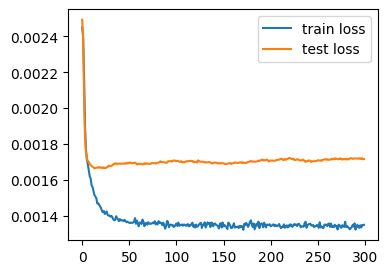

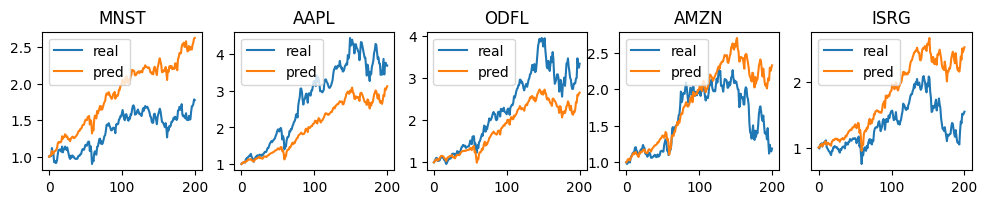

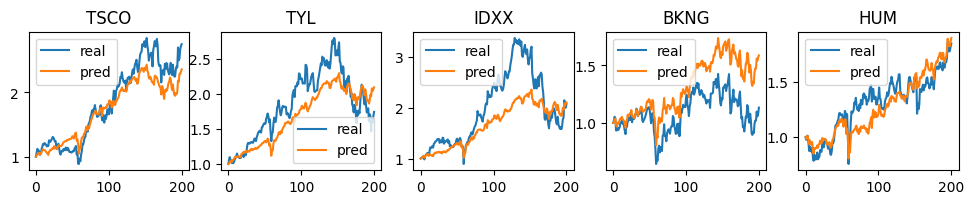

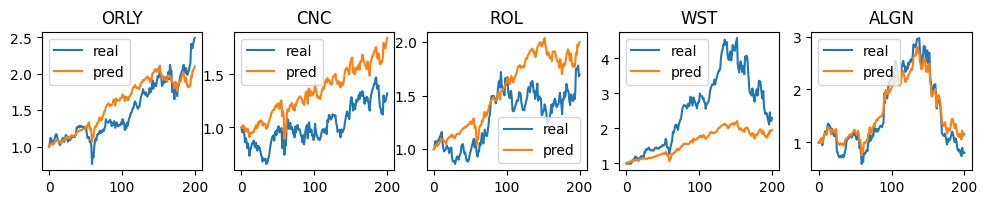

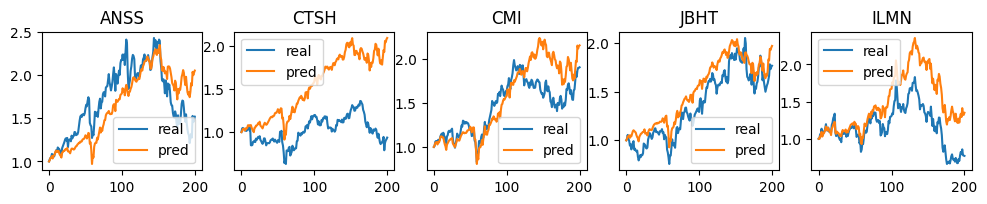

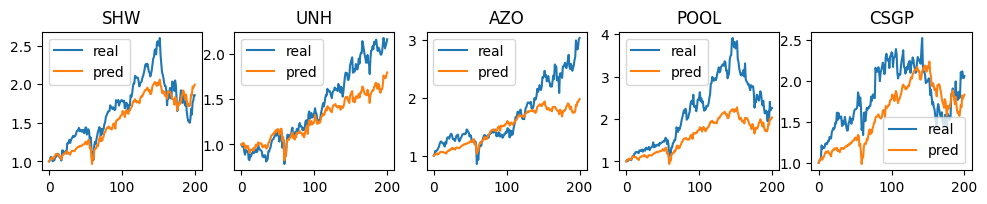

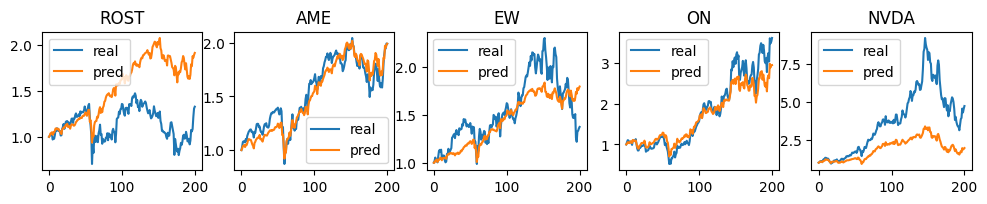

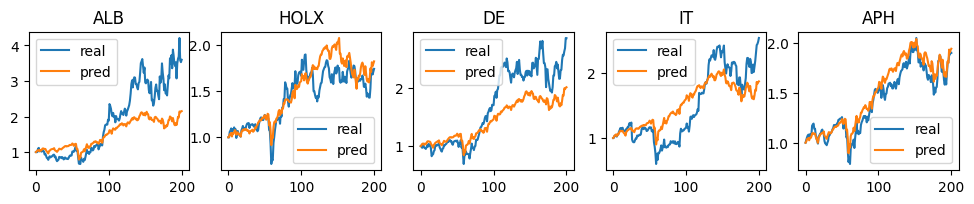

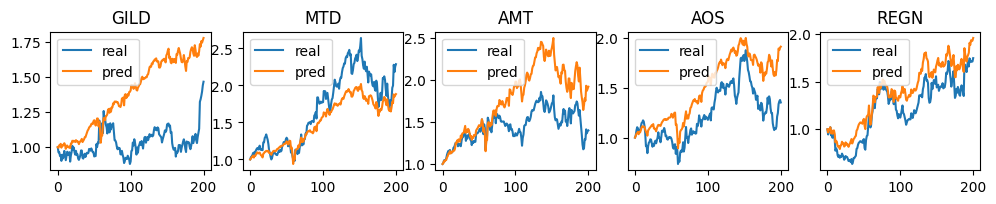

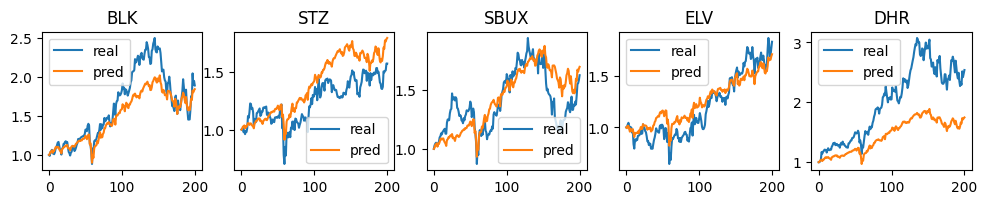

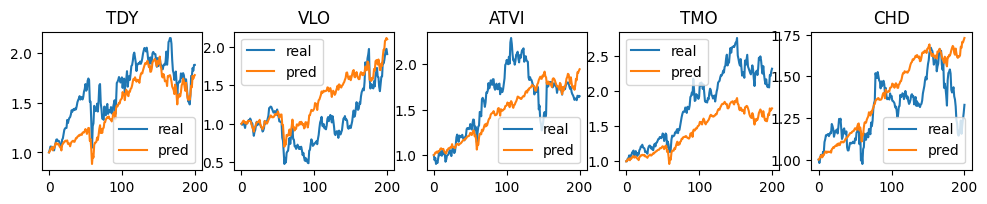

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding
from tensorflow.keras.layers import Flatten, Dot, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pickle

N_FACTORS = 10    # number of factors

# 주간 수익률 데이터를 읽어온다.
rtn_df = pd.read_csv('top50-W-Stock_LogReturn.csv', index_col=0)
rtn_R = np.array(rtn_df)

N_ROW = rtn_R.shape[0]    # time 개수
N_COL = rtn_R.shape[1]    # item (종목) 개수

# mean centering
E = rtn_R.mean(axis=0).reshape(1, N_COL)
cent_R = rtn_R - E

# unpivoting
R = pd.DataFrame(cent_R).stack().reset_index()
R.columns = ['row', 'col', 'rtn']

# 데이터 세트를 생성한다.
x_row = np.array(R['row']).astype('int').reshape(-1, 1)
x_col = np.array(R['col']).astype('int').reshape(-1, 1)
y_rtn = np.array(R['rtn']).reshape(-1, 1)

# 학습 데이터와 시험 데이터를 생성한다.
x_train_row, x_test_row, x_train_col, x_test_col, y_train, y_test = \
                    train_test_split(x_row, x_col, y_rtn, test_size = 0.1)

# 행렬분해 네트워크
x_input_row = Input(batch_shape = (None, x_row.shape[1]))
x_input_col = Input(batch_shape = (None, x_col.shape[1]))

# F-네트워크
x_row_emb = Embedding(N_ROW, N_FACTORS, name='F')(x_input_row)
x_row_emb = Dropout(0.2)(x_row_emb)
x_row_emb = Flatten()(x_row_emb)

# B-네트워크
x_col_emb = Embedding(N_COL, N_FACTORS, name='B')(x_input_col)
x_col_emb = Dropout(0.2)(x_col_emb)
x_col_emb = Flatten()(x_col_emb)

# 추정 수익률 계산
y_output = Dot(axes=1)([x_row_emb, x_col_emb])
model = Model([x_input_row, x_input_col], y_output)
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.0005))

# 학습
hist = model.fit([x_train_row, x_train_col], y_train, 
                  validation_data = ([x_test_row, x_test_col], y_test),
                  batch_size = 256, epochs = 300)

# loss history
plt.figure(figsize=(4,3))
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='test loss')
plt.legend()
plt.show()

# 행렬 F, B
F = model.get_layer('F').get_weights()[0]
B = model.get_layer('B').get_weights()[0]

# F, B로 추정한 주가와 실제 주가 차트를 비교한다.
sym2idx = {k:v for v, k in enumerate(list(rtn_df.columns))}
idx2sym = {v:k for k, v in sym2idx.items()}

rtn_EFB = E + np.dot(F, B.T)  # 추정된 수익률
def calc_price(r):
    prc = [1.0]
    for i in r:
        prc.append(prc[-1] * np.exp(i))
    return prc

# 10행 5열의 plot chart를 그린다.
n_from = -200   # 최근 200 weeks (약 4년)의 주가 차트
for i in np.arange(0, N_COL, 5):
    fig = plt.figure(figsize=(12, 1.8))
    for j in np.arange(i, i+5):
        # 추정 주가와 실제 주가를 계산한다.
        pred_price = calc_price(rtn_EFB[:, j][n_from:])
        real_price = calc_price(rtn_R[:, j][n_from:])
        ax = fig.add_subplot(1, 5, j % 5 + 1)
        ax.plot(real_price, label='real')
        ax.plot(pred_price, label='pred')
        ax.legend()
        ax.set_title(idx2sym[j])
    plt.show() 

In [51]:
B

array([[ 1.62075788e-01,  1.50055021e-01, -7.73092657e-02,
         9.45362449e-02, -1.01175405e-01,  7.73891434e-02,
        -6.98700622e-02, -9.41805094e-02, -2.13212818e-01,
         1.34892091e-01],
       [ 4.36355062e-02,  5.48027381e-02,  3.18340547e-02,
        -5.70228212e-02, -6.17346913e-02, -9.96913575e-03,
         8.50690156e-02,  5.56639694e-02, -9.15233791e-02,
         1.00671370e-02],
       [-5.72779961e-02,  5.52271642e-02,  8.29813555e-02,
        -1.06564701e-01, -6.15523160e-02, -2.10537370e-02,
         2.40792409e-02,  2.87862085e-02, -3.37541588e-02,
         1.21663667e-01],
       [ 4.06195112e-02,  1.10991977e-01, -2.55365446e-02,
         1.72321238e-02, -4.90294173e-02, -7.56801898e-03,
         9.52289328e-02,  1.48331702e-01, -7.47986510e-02,
         4.99872118e-02],
       [ 9.85409766e-02,  1.32242039e-01,  7.57446736e-02,
        -8.12791940e-03, -1.14128433e-01,  8.85320902e-02,
        -7.49214133e-03,  1.78109519e-02, -9.55772325e-02,
         9.

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component1']
               , finalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [4]:
columns = []
for i in range(N_FACTORS):
    columns.append(f'Latent{i+1}')

In [78]:
Beta = pd.DataFrame(B)
Beta.index = rtn_df.keys()
Beta.columns = columns
Beta

,Latent1,Latent2,Latent3,Latent4,Latent5,Latent6,Latent7,Latent8,Latent9,Latent10
MNST,0.117550,0.021371,0.287565,-0.013973,-0.135467,0.173623,-0.142021,0.012150,-0.107419,0.050546
AAPL,0.017306,0.082373,-0.019096,-0.047696,-0.023231,0.043509,-0.088514,0.043915,-0.046433,-0.077419
ODFL,0.067137,-0.015945,-0.063520,-0.126032,0.012790,0.136929,-0.003114,0.015311,-0.079808,-0.057618
AMZN,-0.008670,0.147259,-0.002739,-0.055163,-0.068500,0.028191,-0.047227,0.033797,-0.103676,-0.054293
ISRG,0.138267,0.048216,-0.129971,0.023961,-0.043298,0.025637,-0.071952,0.034452,-0.021409,-0.036623
TSCO,0.030755,0.012082,-0.068279,-0.100269,0.037386,0.092859,-0.075947,-0.015257,-0.080278,-0.038373
TYL,0.037357,0.016014,-0.049729,-0.017648,-0.050087,-0.021680,-0.079550,0.029518,-0.084551,-0.025326
IDXX,0.077903,0.060323,-0.092143,0.007771,-0.028479,0.012439,-0.078325,0.007310,-0.056700,-0.042878
BKNG,-0.175566,0.099974,-0.101474,-0.207412,-0.310989,0.068383,0.053260,0.055169,-0.093285,0.074491
HUM,0.031747,0.073324,-0.148544,0.066544,-0.137288,0.108889,-0.119971,-0.127564,0.107993,0.000224


Text(0.5, 1.0, 'MNST')

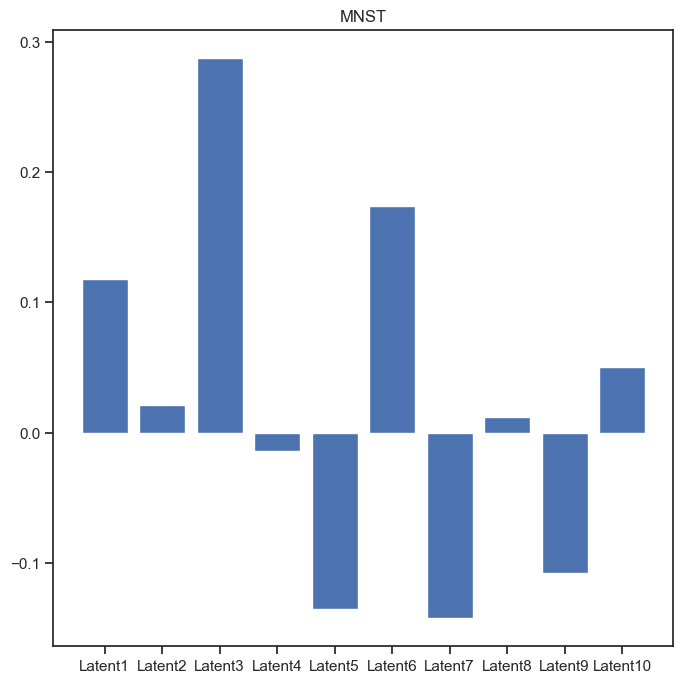

In [83]:
#import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set(style="ticks") 
mpl.rc("figure", figsize=(8, 8))
plt.bar(Beta.columns, Beta.iloc[0, :])
plt.title("MNST")

In [85]:
Beta['Latent8'].sort_values(ascending=False)

ON      0.322539
REGN    0.222103
AMT     0.167917
VLO     0.151402
ALB     0.115212
ILMN    0.113975
CMI     0.098562
APH     0.083185
DE      0.071074
ATVI    0.069442
IT      0.065613
MTD     0.063010
CTSH    0.062159
AME     0.057275
TMO     0.055759
BKNG    0.055169
ANSS    0.053544
NVDA    0.049033
CSGP    0.044061
AAPL    0.043915
AOS     0.043480
TDY     0.038598
BLK     0.038255
ISRG    0.034452
AMZN    0.033797
JBHT    0.031871
GILD    0.031643
TYL     0.029518
POOL    0.029316
SHW     0.028875
ROL     0.020449
SBUX    0.016851
WST     0.015665
ODFL    0.015311
STZ     0.014631
DHR     0.014303
MNST    0.012150
IDXX    0.007310
HOLX    0.004339
ROST   -0.008413
EW     -0.010735
CHD    -0.013322
TSCO   -0.015257
AZO    -0.021460
ORLY   -0.024044
ALGN   -0.082528
ELV    -0.084511
UNH    -0.099341
HUM    -0.127564
CNC    -0.140592
Name: Latent8, dtype: float32

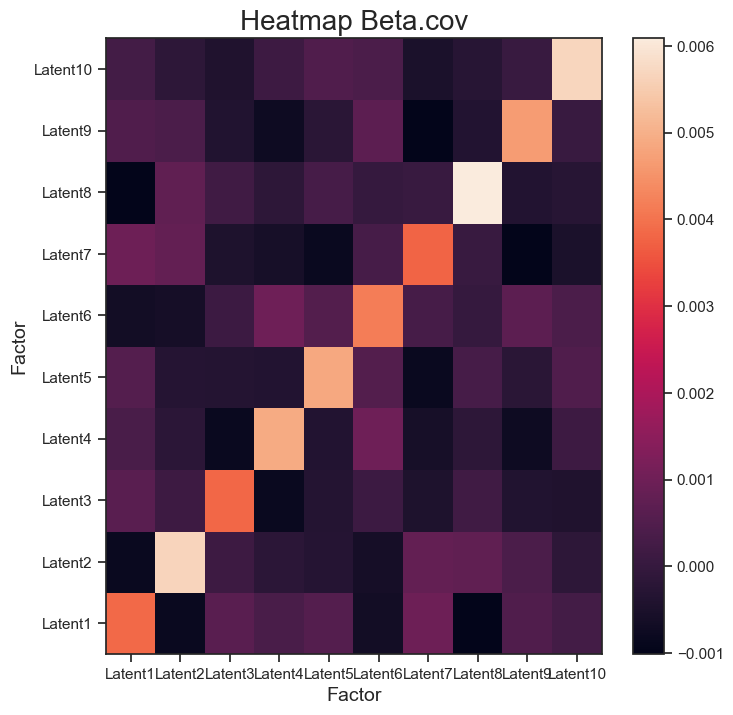

In [97]:
plt.pcolor(Beta.cov())
plt.xticks(np.arange(0.5, len(Beta.cov().columns), 1), Beta.cov().columns)
plt.yticks(np.arange(0.5, len(Beta.cov().index), 1), Beta.cov().index)
plt.title('Heatmap Beta.cov', fontsize=20)
plt.xlabel('Factor', fontsize=14)
plt.ylabel('Factor', fontsize=14)
plt.colorbar()

In [93]:
Beta.T.cov()

,MNST,AAPL,ODFL,AMZN,ISRG,TSCO,TYL,IDXX,BKNG,HUM,...,BLK,STZ,SBUX,ELV,DHR,TDY,VLO,ATVI,TMO,CHD
MNST,0.019234,0.002988,0.002487,0.003917,0.000204,0.002156,0.002183,0.000944,0.003366,0.000764,...,0.002710,0.001885,0.003822,0.001406,0.001868,0.001687,0.002755,0.003315,0.001403,0.001038
AAPL,0.002988,0.003193,0.002282,0.003406,0.002351,0.002352,0.001708,0.002287,0.001923,0.001389,...,0.002460,0.001442,0.002355,0.001426,0.001720,0.001933,0.002444,0.002733,0.001876,0.000807
ODFL,0.002487,0.002282,0.005803,0.001973,0.002323,0.004258,0.001126,0.001813,0.002478,0.000367,...,0.003712,0.002633,0.003114,0.000770,0.002288,0.003454,0.004492,0.001838,0.001947,0.001340
AMZN,0.003917,0.003406,0.001973,0.005072,0.001885,0.002008,0.001960,0.002305,0.005459,0.000887,...,0.002114,0.001119,0.002405,0.001212,0.001642,0.001668,0.001604,0.002900,0.002006,0.000795
ISRG,0.000204,0.002351,0.002323,0.001885,0.005500,0.002162,0.002474,0.003959,-0.000049,0.004334,...,0.003236,0.002931,0.002380,0.003781,0.002601,0.003642,0.002942,0.001735,0.002989,0.001231
TSCO,0.002156,0.002352,0.004258,0.002008,0.002162,0.003948,0.001214,0.002004,0.000774,0.001080,...,0.002953,0.001947,0.002637,0.001121,0.001832,0.002512,0.002476,0.002207,0.001506,0.001347
TYL,0.002183,0.001708,0.001126,0.001960,0.002474,0.001214,0.001819,0.002060,0.000892,0.000686,...,0.001732,0.001266,0.001535,0.000914,0.001375,0.001786,0.001126,0.001662,0.001716,0.000697
IDXX,0.000944,0.002287,0.001813,0.002305,0.003959,0.002004,0.002060,0.003189,0.000110,0.002975,...,0.002449,0.001958,0.002003,0.002587,0.001984,0.002533,0.001394,0.001835,0.002257,0.001077
BKNG,0.003366,0.001923,0.002478,0.005459,-0.000049,0.000774,0.000892,0.000110,0.020752,0.002435,...,0.001313,0.001755,0.002286,0.002958,0.000856,0.001869,0.007543,0.001901,0.002160,0.000060
HUM,0.000764,0.001389,0.000367,0.000887,0.004334,0.001080,0.000686,0.002975,0.002435,0.011535,...,0.001505,0.002572,0.001525,0.008628,0.001464,0.001857,0.003203,0.000602,0.001768,0.000858


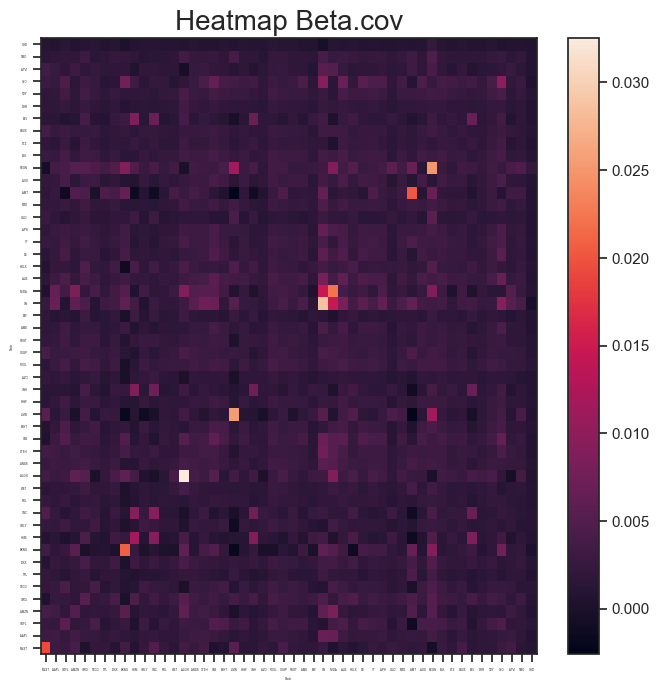

In [100]:
plt.pcolor(Beta.T.cov())
plt.xticks(np.arange(0.5, len(Beta.T.cov().columns), 1), Beta.T.cov().columns, fontsize=2)
plt.yticks(np.arange(0.5, len(Beta.T.cov().index), 1), Beta.T.cov().index, fontsize=2)
plt.title('Heatmap Beta.cov', fontsize=20)
plt.xlabel('Stock', fontsize=2)
plt.ylabel('Stock', fontsize=2)
plt.colorbar()